<a href="https://colab.research.google.com/github/matheusfigueiredoo/detection-of-cyber-attacks/blob/main/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import csv

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv("drive/MyDrive/MQTTset/train70_augmented.csv", nrows=5000000)
test = pd.read_csv("drive/MyDrive/MQTTset/test30_augmented.csv", nrows=3000000)

In [4]:
train = pd.DataFrame(train)
test = pd.DataFrame(test)

In [5]:
# distribuição das targets

print(train['target'].value_counts())
print(test['target'].value_counts())

target
legitimate    2499426
malformed      500978
bruteforce     500848
slowite        500570
flood          499314
dos            498864
Name: count, dtype: int64
target
legitimate    1499770
dos            300558
slowite        300371
flood          300107
malformed      299830
bruteforce     299364
Name: count, dtype: int64


In [6]:
'''
'rows' e o vetor que sera usado para acumular as linhas que serao excluidas a fim de balancear
as targets
'''
rows_train = []
rows_test = []

for i in train.index:
    if train['target'][i] == 'legitimate':
        rows_train.append(i)

for i in test.index:
    if test['target'][i] == 'legitimate':
        rows_test.append(i)

In [7]:
# aqui, e feita a leitura da diferenca para igualar os valores

rows_train = rows_train[:1999426]
rows_test = rows_test[:1199470]

In [8]:
# atualizacao e igualacao dos valores

train = train.drop(rows_train)
test = test.drop(rows_test)

print("Dados de treino: ", train['target'].value_counts())
print("Dados de teste: ", test['target'].value_counts())

Dados de treino:  target
malformed     500978
bruteforce    500848
slowite       500570
legitimate    500000
flood         499314
dos           498864
Name: count, dtype: int64
Dados de teste:  target
dos           300558
slowite       300371
legitimate    300300
flood         300107
malformed     299830
bruteforce    299364
Name: count, dtype: int64


In [9]:
# pre processamento de dados
# separacao de features e targets

X_train = train.iloc[:,:-1]
y_train = train['target']

X_test = test.iloc[:,:-1]
y_test = test['target']

print(X_train.shape)
print(X_test.shape)

(3000574, 33)
(1800530, 33)


In [10]:
# transformacao de features e targets categoricas em numeros inteiros

from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()

In [11]:
# features
X_train['tcp.flags'] = label.fit_transform(X_train['tcp.flags'])
X_train['mqtt.conack.flags'] = label.fit_transform(X_train['mqtt.conack.flags'])
X_train['mqtt.hdrflags'] = label.fit_transform(X_train['mqtt.hdrflags'])
X_train['mqtt.protoname'] = label.fit_transform(X_train['mqtt.protoname'])
X_train['mqtt.msg'] = label.fit_transform(X_train['mqtt.msg'])
X_train['mqtt.conflags'] = label.fit_transform(X_train['mqtt.conflags'])

X_test['tcp.flags'] = label.fit_transform(X_test['tcp.flags'])
X_test['mqtt.conack.flags'] = label.fit_transform(X_test['mqtt.conack.flags'])
X_test['mqtt.hdrflags'] = label.fit_transform(X_test['mqtt.hdrflags'])
X_test['mqtt.protoname'] = label.fit_transform(X_test['mqtt.protoname'])
X_test['mqtt.msg'] = label.fit_transform(X_test['mqtt.msg'])
X_test['mqtt.conflags'] = label.fit_transform(X_test['mqtt.conflags'])

# targets
label.fit(y_train)
label.fit(y_test)
y_train = label.transform(y_train)
y_test = label.transform(y_test)

In [12]:
# ajuste de dados

# columns_0 são as colunas com dados iguais a 0

columns_0 = ['mqtt.conack.flags.reserved', 'mqtt.conack.flags.sp', 'mqtt.conflag.qos',
           'mqtt.conflag.reserved', 'mqtt.conflag.retain', 'mqtt.conflag.willflag',
           'mqtt.retain', 'mqtt.sub.qos', 'mqtt.suback.qos', 'mqtt.willmsg', 'mqtt.willmsg_len',
           'mqtt.willtopic', 'mqtt.willtopic_len']

X_train = X_train.drop(columns_0, axis=1)
X_test = X_test.drop(columns_0, axis=1)


print(X_train.shape)
print(X_test.shape)

(3000574, 20)
(1800530, 20)


In [13]:
X_train = X_train.values
X_test = X_test.values

print(type(X_train))
print(type(X_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [14]:
# normalização dos dados
# seleção de features

# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# scaler = StandardScaler()

# scaler.fit(X_train)
# scaler.fit(X_test)

# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

# pca = PCA()

# pca.fit(X_train)
# pca.fit(X_test)

# X_train = pca.transform(X_train)
# X_test = pca.transform(X_test)

In [15]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

clf.fit(X_train, y_train)

print("Accuracy train: {}".format(clf.score(X_train, y_train)))
print("Accuracy test: {}".format(clf.score(X_test, y_test)))

Accuracy train: 0.8797190137620335
Accuracy test: 0.879815387691402


In [16]:
# metrics

from sklearn.metrics import classification_report

# predição de valores

predict = clf.predict(X_test)
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83    299364
           1       0.91      0.89      0.90    300558
           2       0.87      0.88      0.88    300107
           3       0.85      0.90      0.88    300300
           4       0.89      0.72      0.80    299830
           5       1.00      1.00      1.00    300371

    accuracy                           0.88   1800530
   macro avg       0.88      0.88      0.88   1800530
weighted avg       0.88      0.88      0.88   1800530



In [17]:
# confusion matrix

from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test, predict)
print(matrix)

[[265446  12864    604    216  20234      0]
 [  3915 267091  10326  13888   5338      0]
 [   573   2409 264810  31741    574      0]
 [    32   4236  25179 270654    199      0]
 [ 72196   7986   2839   1047 215762      0]
 [     0      0      0      0      0 300371]]


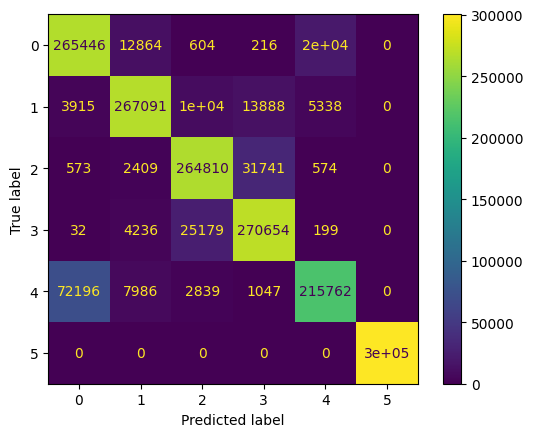

In [18]:
# display matrix

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

%matplotlib inline

cm = confusion_matrix(y_test, predict, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

disp.plot()
plt.show()